# Notes
1. Deleting the rows with missing values for estimated revenue and review scores rating
2. Fill host_response_time with mode
3. Fill 'host_acceptance_rate' and 'host_response_rate' with median values
4. Show relation that the review ratings are related to average estimated revenue
5. FInd the actionable factors that associate with high review rating clusters
6. Fill values based on that

**Limitation** - We have to mention that there is association between high review ratings and the revenue but we can't prove if there is causual effect

# Data Pre-processing

In [11]:
import pandas as pd
import numpy as np
listings = pd.read_csv('Original_listings.csv')

# Remove unimportant columns
col_del = ['listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url','host_url','host_name',
          'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'neighbourhood', 'minimum_minimum_nights', 
           'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 
          'calendar_updated', 'availability_30', 'availability_60', 'availability_90', 'availability_365' ,'calendar_last_scraped', 'availability_eoy',
          'first_review', 'license', 'has_availability']
listings.drop(columns=col_del, inplace=True)

'''
Since the goal of our project is to find the relation between estimated revenue and review scores and improve review scores, we deleted the data with no values.
'''
listings.dropna(subset=['review_scores_rating','estimated_revenue_l365d'], inplace=True)

# Remove values of host_since, host_is_superhost
listings.dropna(subset=['host_since','host_is_superhost', 'bathrooms', 'bedrooms', 'beds'], inplace=True)

#Convert host_since to datetime and create a field with the duration value in years
listings['host_since'] = pd.to_datetime(listings['host_since'])
listings['host_years_active'] = pd.Timestamp.now().year - listings['host_since'].dt.year

# Drop the columns
listings.drop(columns=['host_verifications','neighbourhood_cleansed','property_type','bathrooms_text'],inplace=True)

listings['neighbourhood'] = listings['neighbourhood_group_cleansed']
# Dummies - neighbourhood_group_cleansed, room_type
listings = pd.get_dummies(listings, columns=['neighbourhood_group_cleansed', 'room_type'], dtype=int)

#Include only the year for the 'last_review' column
listings['last_review'] = pd.to_datetime(listings['last_review'], format='mixed', dayfirst=True, errors='coerce').dt.year

#Remove the dollar sign and convert to floats
listings['price'] = listings['price'].replace('[\$,]', '', regex=True).astype(float)

# Converting binary columns into numeric values - has_availability, instant_bookable, host_is_superhost, host_identity_verified, host_has_profile_pic
binary_columns = ['instant_bookable', 'host_is_superhost','host_has_profile_pic', 'host_identity_verified']
for col in binary_columns:
    listings[col] = listings[col].map({'t': 1, 'f': 0, 'yes': 1, 'no': 0})

# Changing the percentages to numeric values
percentage_cols = ['host_acceptance_rate', 'host_response_rate']
for col in percentage_cols:
    listings[col] = listings[col].str.rstrip('%').astype(float) / 100  # Converts to scale of 0-1

# fill 'host_acceptance_rate' and 'host_response_rate' with median values
percentage_cols = ['host_acceptance_rate', 'host_response_rate']

for col in percentage_cols:
    listings[col].fillna(listings[col].median(), inplace=True)

#Convert host_response_time into numerical variables
'''
host_response_time:
1- within an hour
2- within a few hours
3- within a day
4- a few days or more
'''
# Fill host_response_time with mode value
mode_value = listings['host_response_time'].mode()[0]
listings['host_response_time'].fillna(mode_value, inplace=True)
order = ['within an hour', 'within a few hours', 'within a day', 'a few days or more']
listings['host_response_time'] = pd.Categorical(listings['host_response_time'], categories=order, ordered=True).codes + 1

# Remove outliers using IQR method
Q1 = listings['estimated_revenue_l365d'].quantile(0.25)
Q3 = listings['estimated_revenue_l365d'].quantile(0.75)
IQR = Q3 - Q1

# Keep only rows within 1.5 * IQR range
df = listings[
    (listings['estimated_revenue_l365d'] >= (Q1 - 1.5 * IQR)) &
    (listings['estimated_revenue_l365d'] <= (Q3 + 1.5 * IQR))
]

df.shape


(13528, 52)

# Find Optimal K- value and clusters of review scores
Cluster listings by their 7 review dimensions - review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location, review_scores_value

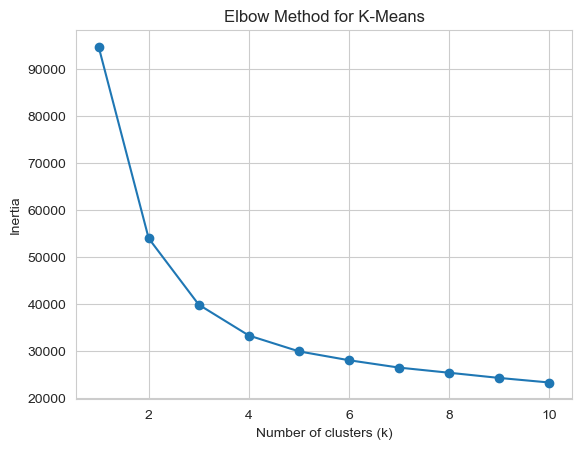

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Review Columns
review_cols = [
    'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value'
]
reviews_df = df[review_cols]

# Standardize the Data
scaler = StandardScaler()
reviews_scaled = scaler.fit_transform(reviews_df)

#Elbow Method (to choose optimal k)
inertia = []
K_range = range(1, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(reviews_scaled)
    inertia.append(km.inertia_)
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for K-Means')
plt.grid(True)
plt.show()

In [13]:
# Fit K-means using chosen k = 3
kmeans = KMeans(n_clusters = 3, random_state = 42, n_init = 10)
raw_labels = kmeans.fit_predict(reviews_scaled)

# Add raw cluster labels
temp = reviews_df.copy()
temp['raw_cluster'] = raw_labels

# Columns used for clustering
review_cols = ['review_scores_accuracy', 'review_scores_cleanliness',
               'review_scores_checkin', 'review_scores_communication',
               'review_scores_location', 'review_scores_value',
               'review_scores_rating']

# Compute average review score per cluster across ALL dimensions
cluster_means_full = temp.groupby('raw_cluster')[review_cols].mean()
# Compute an overall average score for ranking clusters
cluster_overall = cluster_means_full.mean(axis=1)
print('cluster_overall:', cluster_overall)
# Sort clusters by overall review quality (highest first)
ordered_clusters = cluster_overall.sort_values(ascending=False).index.tolist()
print('ordered_clusters:',ordered_clusters)
# Map raw → ordered
label_map = {ordered_clusters[i]: 3 - i for i in range(len(ordered_clusters))}
print('label_map:',label_map)
# Apply
df.loc[temp.index, 'review_cluster'] = temp['raw_cluster'].map(label_map)
df['review_cluster'].value_counts()

cluster_overall: raw_cluster
0    4.853565
1    2.466842
2    4.370120
dtype: float64
ordered_clusters: [0, 2, 1]
label_map: {0: 3, 2: 2, 1: 1}


C:\Users\USER\AppData\Local\Temp\ipykernel_35048\1167239396.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[temp.index, 'review_cluster'] = temp['raw_cluster'].map(label_map)
C:\Users\USER\AppData\Local\Temp\ipykernel_35048\1167239396.py:27: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[temp.index, 'review_cluster'] = temp['raw_cluster'].map(label_map)


3    11138
2     2200
1      190
Name: review_cluster, dtype: int64

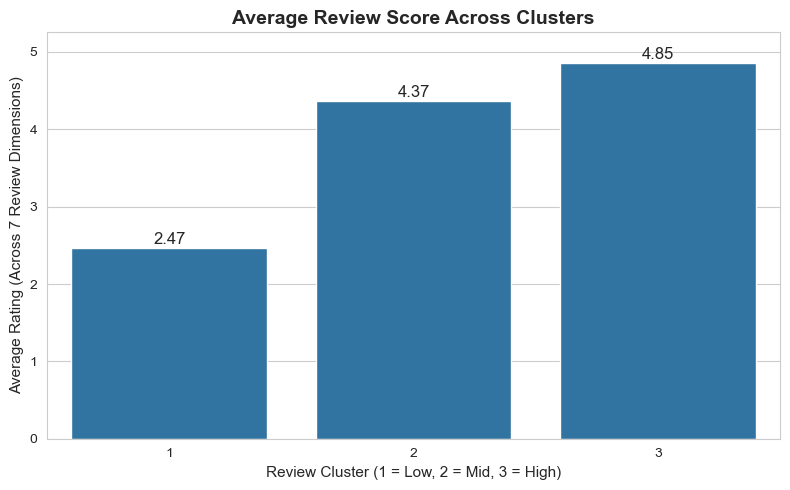

In [14]:
# Compute mean of ALL rating variables for each cluster
avg_cluster_rating = (
    filtered_listings
    .groupby('review_cluster')[review_cols]
    .mean()
    .mean(axis=1)
    .reset_index(name='avg_rating')
)

# Sort clusters
avg_cluster_rating = avg_cluster_rating.sort_values('review_cluster')

sns.set_style("whitegrid")
alpha_val = 0.85

plt.figure(figsize=(8, 5))
sns.barplot(
    data=avg_cluster_rating,
    x='review_cluster',
    y='avg_rating',
    color=sns.color_palette()[0] 
)

for i, row in avg_cluster_rating.iterrows():
    plt.text(
        i,
        row['avg_rating'] + 0.05,
        f"{row['avg_rating']:.2f}",
        ha='center',
        fontsize=12,
    )

plt.title("Average Review Score Across Clusters", fontsize=14, weight='bold')
plt.xlabel("Review Cluster (1 = Low, 2 = Mid, 3 = High)", fontsize=11)
plt.ylabel("Average Rating (Across 7 Review Dimensions)", fontsize=11)
plt.ylim(0, avg_cluster_rating['avg_rating'].max() + 0.4)
plt.tight_layout()
plt.show()

#### review_cluster =

1 → low-review listings

2 → mid-review listings

3 → high-review listings

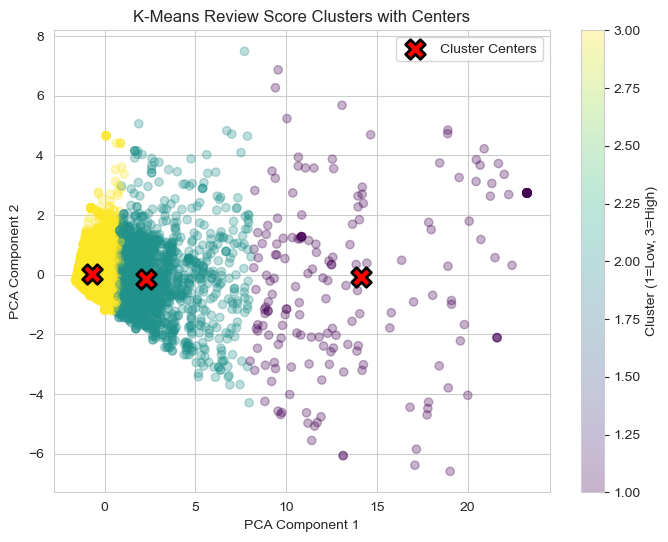

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCA to 2 components
pca = PCA(n_components=2)
pca_comp = pca.fit_transform(reviews_scaled)

# Get cluster centers in PCA space
centers_scaled = kmeans.cluster_centers_
centers_pca = pca.transform(centers_scaled)

# Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    pca_comp[:,0], pca_comp[:,1],
    c=filtered_listings.loc[filtered_listings[review_cols].dropna().index, 'review_cluster'],
    cmap='viridis',
    alpha=0.3
)

# plot cluster centers
plt.scatter(
    centers_pca[:,0], centers_pca[:,1],
    c='red',
    s=200,
    marker='X',
    edgecolors='black',
    linewidths=2,
    label='Cluster Centers'
)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Review Score Clusters with Centers')
plt.colorbar(scatter, label='Cluster (1=Low, 3=High)')
plt.legend()
plt.show()

# Review ratings are related to average estimated revenue

   review_cluster  estimated_revenue_l365d
0               1              3996.836842
1               2             10564.256818
2               3             15365.810379


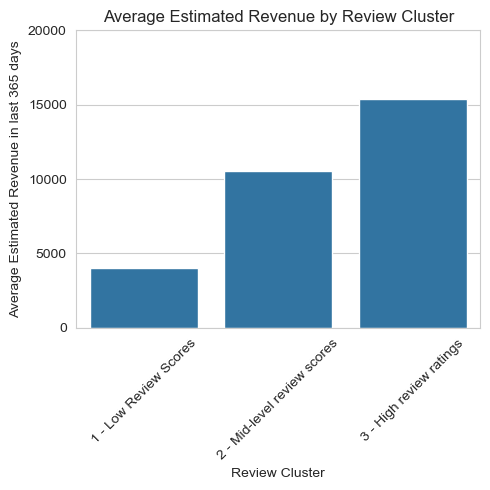

(13528, 53)

In [16]:
# Group by review_cluster and calculate average estimated revenue
avg_revenue = filtered_listings.groupby('review_cluster')['estimated_revenue_l365d'].mean().reset_index()
print(avg_revenue)
cluster_labels = {
    1.0: '1 - Low Review Scores',
    2.0: '2 - Mid-level review scores',
    3.0: '3 - High review ratings'
}

avg_revenue['cluster_name'] = avg_revenue['review_cluster'].map(cluster_labels)

# Plot
plt.figure(figsize=(5,5))

sns.barplot(
    data=avg_revenue,
    x='cluster_name',
    y='estimated_revenue_l365d',
    color=sns.color_palette()[0]   
)

plt.xlabel('Review Cluster')
plt.ylabel('Average Estimated Revenue in last 365 days')
plt.title('Average Estimated Revenue by Review Cluster')

max_val = avg_revenue['estimated_revenue_l365d'].max()
yticks = np.arange(0, max_val + 5000, 5000)
plt.yticks(yticks)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

avg_revenue
filtered_listings.shape

# Insights

## Insight 1 - Differences in Review Scores
**What differentiates low-performing hosts from high-performing hosts in terms of customer experience?**

Insights:
1. “Value” shows the largest drop

Low-rated listings suffer the most in perceived value. Guests feel the price does not match the experience, making pricing expectation mismatch the strongest driver of poor ratings.

2. “Accuracy” is the second-largest weakness

Large declines in accuracy indicate low-rated hosts often misrepresent the listing (photos, amenities, description). This expectation gap strongly contributes to dissatisfaction.

3. Cleanliness and Communication also decline substantially

These two dimensions show meaningful drops, suggesting operational issues such as inconsistent cleaning standards and slower/less effective communication.

**Low-rated listings fall behind mainly due to misaligned expectations (accuracy), poor value perception, and cleanliness issues. These are the most actionable areas for improving guest satisfaction and boosting ratings under LL18.**

 Mean review scores by cluster
   review_cluster  review_scores_accuracy  review_scores_cleanliness  \
0               1                    2.31                       2.38   
1               2                    4.37                       4.22   
2               3                    4.88                       4.82   

   review_scores_checkin  review_scores_communication  review_scores_location  \
0                   2.89                         2.57                    3.06   
1                   4.59                         4.52                    4.49   
2                   4.92                         4.92                    4.80   

   review_scores_value  review_scores_rating  
0                 1.93                  2.13  
1                 4.11                  4.29  
2                 4.77                  4.86  

High-rating cluster label: 3.0
Low-rating cluster label:  1.0

Drop in avg dimension scores (High --> Low)
review_scores_value            2.834
review_scores_accuracy

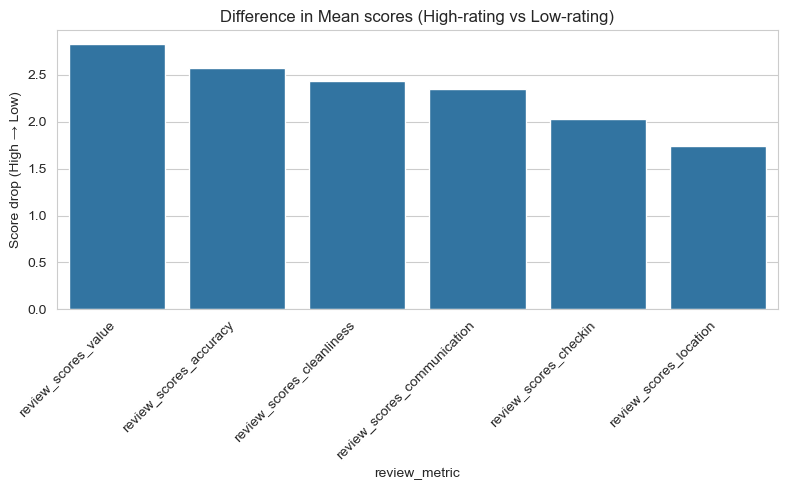

In [17]:
# Set the review score columns (EXCLUDING review_scores_rating)
score_cols = [
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value'
]

# Keep rating separately ONLY for ordering clusters
rating_col = 'review_scores_rating'

# Mean scores by cluster
cluster_means = (
    df.groupby('review_cluster', as_index=False)[score_cols + [rating_col]]
      .mean()
)

print(" Mean review scores by cluster")
print(cluster_means.round(2))

# Identify High-rating and Low-rating clusters (using rating only)
cluster_means_sorted = cluster_means.sort_values(rating_col, ascending=False)

high_cluster = cluster_means_sorted.iloc[0]['review_cluster']
low_cluster  = cluster_means_sorted.iloc[-1]['review_cluster']

print(f"\nHigh-rating cluster label: {high_cluster}")
print(f"Low-rating cluster label:  {low_cluster}")

cluster_means_indexed = cluster_means.set_index('review_cluster')

high_scores = cluster_means_indexed.loc[high_cluster, score_cols]
low_scores  = cluster_means_indexed.loc[low_cluster, score_cols]

# Compute drop from High → Low for each dimension (rating excluded)
drop_high_to_low = (high_scores - low_scores).sort_values(ascending=False)

print("\nDrop in avg dimension scores (High --> Low)")
print(drop_high_to_low.round(3))

# Convert to DataFrame
drop_df = drop_high_to_low.reset_index()
drop_df.columns = ['review_metric', 'drop_high_to_low']

print("\n=== Sorted by largest drop (biggest weaknesses at top) ===")
print(drop_df)

# Plot (rating excluded)
plt.figure(figsize=(8,5))
sns.barplot(
    data=drop_df,
    x='review_metric',
    y='drop_high_to_low',
    color=sns.color_palette()[0] 
)

plt.xticks(rotation=45, ha='right')
plt.ylabel('Score drop (High → Low)')
plt.title('Difference in Mean scores (High-rating vs Low-rating)')
plt.tight_layout()
plt.show()

## Insight 2 - Host Characteristics
**2. Both acceptance rate and occupancy increase steadily from Cluster 1 → Cluster 2 → Cluster 3:**
         
         - review quality improves, hosts consistently show better operational outcomes
         
         - strong positive association between review quality and booking-related performance
         
**Pattern: higher-review listings tend to both accept more booking requests and achieve higher occupancy - indicating that high-review listings convert demand more effectively and are booked for more nights. However, this relationship is correlational rather than causal; the metrics move together, but one does not necessarily cause the other**

C:\Users\USER\AppData\Local\Temp\ipykernel_35048\2778854070.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster_label'] = df['review_cluster'].map(cluster_labels)
C:\Users\USER\AppData\Local\Temp\ipykernel_35048\2778854070.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster_label'] = pd.Categorical(df['cluster_label'], categories=order, ordered=True)


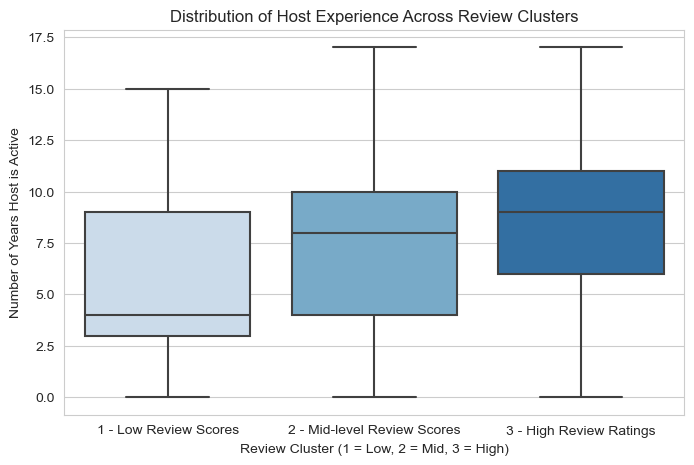

In [18]:
# Map clusters to labels
cluster_labels = {
    1: '1 - Low Review Scores',
    2: '2 - Mid-level Review Scores',
    3: '3 - High Review Ratings'
}

df['cluster_label'] = df['review_cluster'].map(cluster_labels)
order = [
    '1 - Low Review Scores',
    '2 - Mid-level Review Scores',
    '3 - High Review Ratings'
]

df['cluster_label'] = pd.Categorical(df['cluster_label'], categories=order, ordered=True)

plt.figure(figsize=(8,5))

sns.boxplot(
    data=df,
    x='cluster_label',     
    y='host_years_active',
    order=order,            
    palette=sns.color_palette("Blues", 3)
)

plt.title("Distribution of Host Experience Across Review Clusters")
plt.xlabel("Review Cluster (1 = Low, 2 = Mid, 3 = High)")
plt.ylabel("Number of Years Host is Active")

plt.show()



Columns used: ['review_cluster', 'host_years_active', 'number_of_reviews']

ANOVA for number_of_reviews:
  F-statistic = 126.110, p-value = 5.441e-55
Statistically significant differences across clusters.

=== OLS: number_of_reviews ~ Cluster + Experience ===
                            OLS Regression Results                            
Dep. Variable:      number_of_reviews   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     132.8
Date:                Fri, 26 Dec 2025   Prob (F-statistic):           8.06e-85
Time:                        11:43:40   Log-Likelihood:                -79886.
No. Observations:               13528   AIC:                         1.598e+05
Df Residuals:                   13524   BIC:                         1.598e+05
Df Model:                           3                                         
Covariance Type:            n

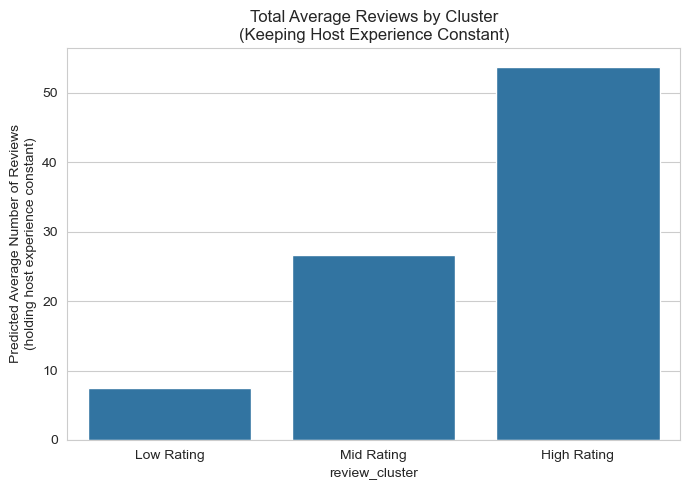

In [19]:
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm

print("Columns used:", ['review_cluster', 'host_years_active', 'number_of_reviews'])

# Statistical test -  ANOVA: number_of_reviews ~ cluster
def anova_by_cluster(data, col):
    # Get cluster IDs
    clusters = sorted(data['review_cluster'].dropna().unique())
    # Values per cluster
    groups = [
        data.loc[data['review_cluster'] == c, col].dropna()
        for c in clusters
    ]
    
    # One-way ANOVA
    f_stat, p_val = stats.f_oneway(*groups)
    print(f"\nANOVA for {col}:")
    print(f"  F-statistic = {f_stat:.3f}, p-value = {p_val:.3e}")
    if p_val < 0.05:
        print("\033[1mStatistically significant differences across clusters.\033[0m")
    else:
        print("\033[1mNo statistically significant difference across clusters.\033[0m")

anova_by_cluster(df, 'number_of_reviews')

# OLS: outcome ~ C(cluster) + host_years_active

def run_ols(outcome):
    formula = f'{outcome} ~ C(review_cluster) + host_years_active'
    model = smf.ols(formula, data=df).fit()
    print(f"\n=== OLS: {outcome} ~ Cluster + Experience ===")
    print(model.summary())
    return model

# Raw outcome
ols_reviews = run_ols('number_of_reviews')

# Visualization: Predicted reviews by cluster holding host experience constant
# Use the raw reviews model for prediction
model = ols_reviews

# Choose a fixed host experience (mean)
fixed_exp = df['host_years_active'].mean()

# Create a prediction dataframe: 1 row per cluster
pred_df = pd.DataFrame({
    'review_cluster': [1, 2, 3],
    'host_years_active': fixed_exp
})

# Get predicted review counts
pred_df['predicted_reviews'] = model.predict(pred_df)

# Plot
plt.figure(figsize=(7, 5))
sns.barplot(
    data=pred_df,
    x='review_cluster',
    y='predicted_reviews',
    color=sns.color_palette()[0]  
)
plt.xticks([0, 1, 2], ['Low Rating', 'Mid Rating', 'High Rating'])  
plt.ylabel("Predicted Average Number of Reviews\n(holding host experience constant)")
plt.title("Total Average Reviews by Cluster\n(Keeping Host Experience Constant)")
plt.tight_layout()
plt.show()

(After Host experience controlled)
host_response_rate : No meaningful difference - NOT an operational behavior that differentiates high-review listings
**host_acceptance_rate** : major differentiator - High-review listings accept 8–11% more booking requests than low-review listings, even at the same experience level. (Acceptance rate is a real behavioral driver of high review performance)
host_response_time : NOT significantly faster - Response speed does NOT explain why some listings achieve higher review clusters.
Faster response does not predict cluster membership once experience is controlled.
estimated_occupancy_l365d :

Logistic Regression:
instant_bookable : Instant booking is NOT a key behavior that separates high-review from low-review listings.
It matters for Cluster 2, but not for the top cluster.

**Overall Summary:**
Overall, our regression analysis shows that operational behaviors differ significantly across review-based clusters, even after controlling for host experience. Acceptance rate and occupancy emerge as the strongest behavioral drivers distinguishing high-review listings from lower-performing ones: high-review hosts accept a greater share of booking requests and achieve substantially more nights booked per year, regardless of how long they have been active on Airbnb. In contrast, response rate, response time, and instant booking do not meaningfully distinguish high-review listings once experience is accounted for, indicating that these behaviors are not primary contributors to review-based cluster differences. Together, these results suggest that the high-review cluster reflects genuine, experience-independent operational quality—particularly in terms of how effectively hosts convert guest inquiries into completed bookings.

## Insight 3 - Target Neighborhoods

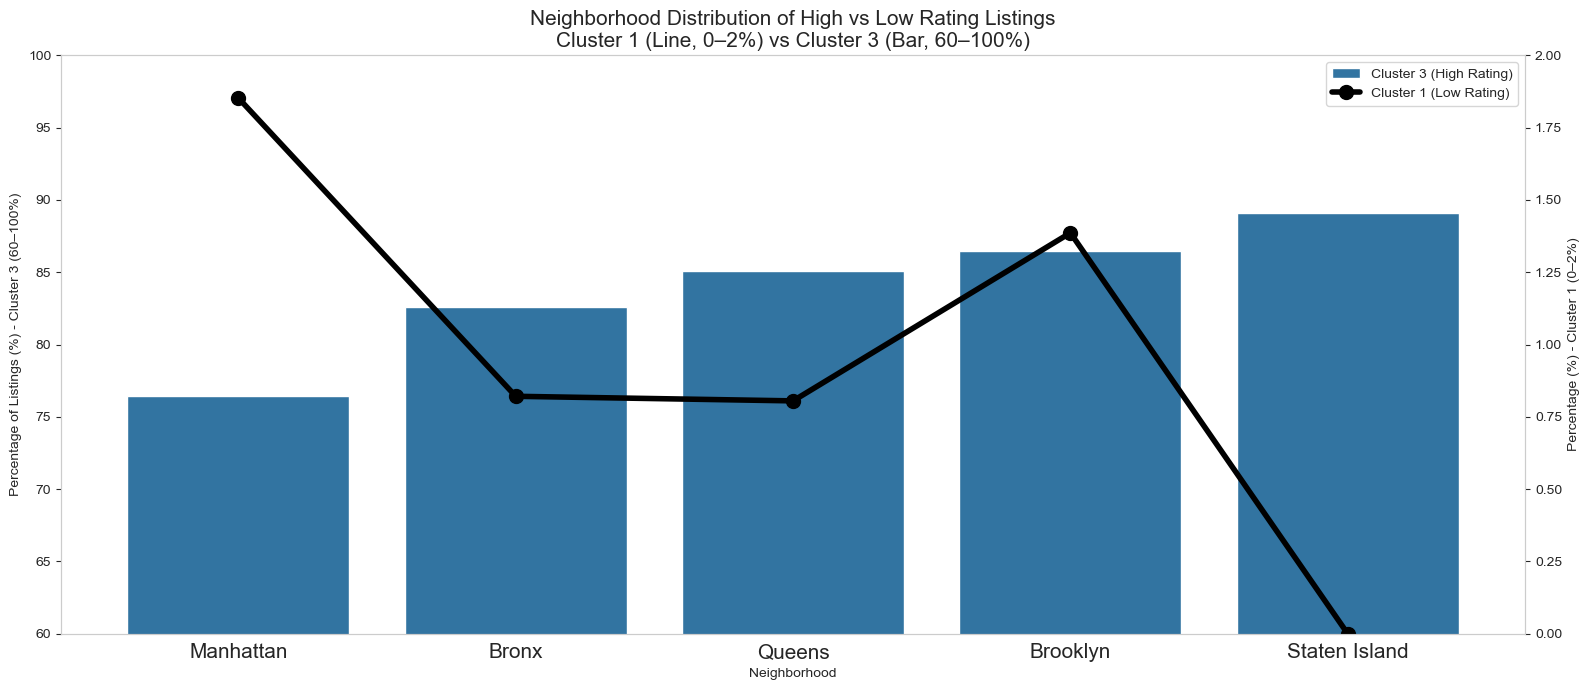

In [20]:
# Compute percentages for Cluster 1 & Cluster 3
total = df.groupby('neighbourhood').size()
c1 = df[df['review_cluster'] == 1].groupby('neighbourhood').size()
c3 = df[df['review_cluster'] == 3].groupby('neighbourhood').size()

result = pd.concat([total, c1, c3], axis=1)
result.columns = ['total', 'c1', 'c3']
result = result.fillna(0)

result['pct_c1'] = result['c1'] / result['total'] * 100
result['pct_c3'] = result['c3'] / result['total'] * 100

# Sort by pct_c3 ascending
result = result.sort_values('pct_c3', ascending=True)

# Plot
fig, ax1 = plt.subplots(figsize=(16, 7))

# Cluster 3 (Bars) using seaborn
sns.barplot(
    x=result.index,
    y=result['pct_c3'],
    ax=ax1,
    label='Cluster 3 (High Rating)',
    color=sns.color_palette()[0],   
)

ax1.grid(False)
ax1.set_ylim(60, 100)
ax1.set_ylabel("Percentage of Listings (%) - Cluster 3 (60–100%)")
ax1.set_xlabel("Neighborhood")

# Cluster 1 (Line on secondary axis)
ax2 = ax1.twinx()
ax2.plot(
    result.index,
    result['pct_c1'],
    label='Cluster 1 (Low Rating)',
    marker='o',
    linewidth=4,
    markersize=10,
    color='black'
)


ax2.grid(False)
ax2.set_ylim(0, 2)
ax2.set_ylabel("Percentage (%) - Cluster 1 (0–2%)")
plt.title(
    "Neighborhood Distribution of High vs Low Rating Listings\n"
    "Cluster 1 (Line, 0–2%) vs Cluster 3 (Bar, 60–100%)", fontsize=15
)
ax1.set_xticklabels(result.index, fontsize=15)

# Combined legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

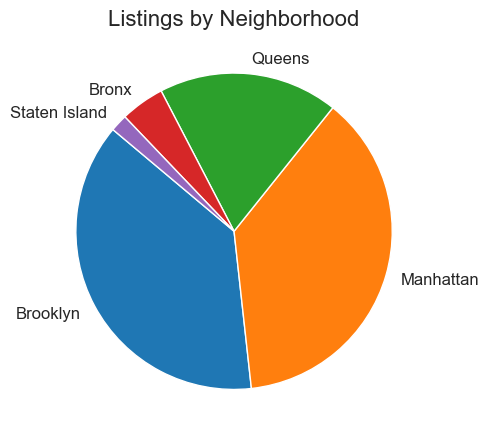

In [21]:
# Compute and sort number of listings
listings_by_neigh = (
    df.groupby('neighbourhood')
      .size()
      .reset_index(name='num_listings')
      .sort_values('num_listings', ascending=False)
)

# Pie Chart
plt.figure(figsize=(5,5))
plt.pie(
    listings_by_neigh['num_listings'],
    labels=listings_by_neigh['neighbourhood'],
    startangle=140,
    textprops={'fontsize': 12}
)
plt.title("Listings by Neighborhood", fontsize=16)
plt.tight_layout()
plt.show()

## Insight 4 - Demand Follows Quality, not Price
**1. Price does not meaningfully differ across review clusters (p = 0.68), but occupancy does (p < 10⁻⁶³).
This means high-review listings earn more not because they charge higher prices, but because they are booked far more often.
Improving review quality has a much stronger impact on revenue than adjusting nightly price.**

Cluster 3 listings achieve higher occupancy without significantly increasing price, suggesting that guest demand is driven more by review quality than by pricing levels.

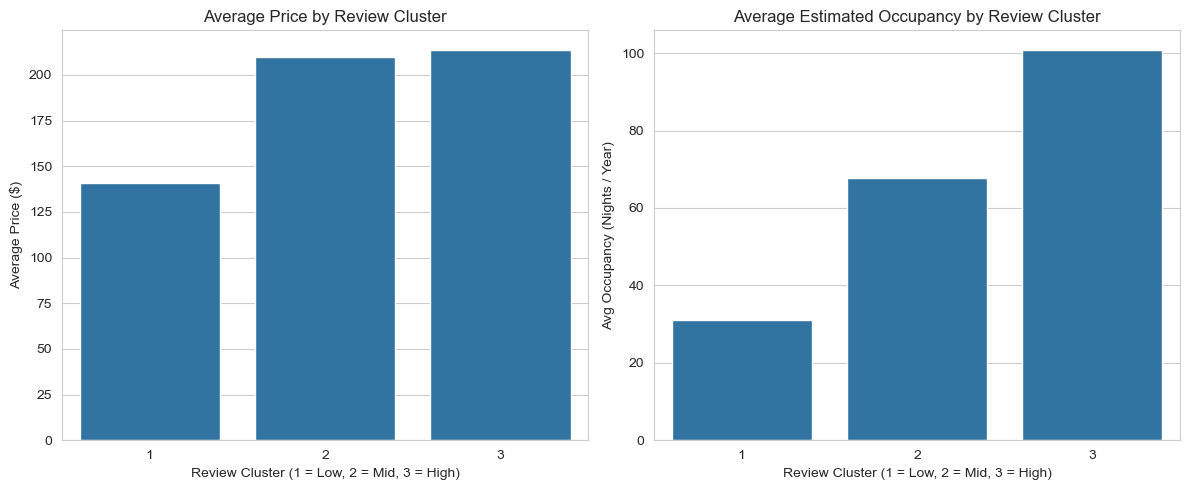

Price - Cluster sizes: 190 2200 11138

ANOVA results - Price:
F-statistic: 0.3856, p-value: 6.8002e-01
=> Fail to reject H0: Mean prices are not significantly different across clusters.

Occupancy - Cluster sizes: 190 2200 11138

ANOVA results - Occupancy:
F-statistic: 146.6640, p-value: 9.6721e-64
Reject H0: Mean occupancy differs significantly across clusters.


In [22]:
from scipy.stats import f_oneway

# Aggregate metrics
# Average price per cluster
avg_price_cluster = (
    filtered_listings
    .groupby('review_cluster')['price']
    .mean()
    .reset_index()
)

# Average occupancy per cluster
avg_occupancy_cluster = (
    filtered_listings
    .groupby('review_cluster')['estimated_occupancy_l365d']
    .mean()
    .reset_index()
)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# --- Left: Average Price by Cluster ---
sns.barplot(
    data=avg_price_cluster,
    x='review_cluster',
    y='price',
    ax=axes[0],
    color=sns.color_palette()[0]
)
axes[0].set_title('Average Price by Review Cluster')
axes[0].set_xlabel('Review Cluster (1 = Low, 2 = Mid, 3 = High)')
axes[0].set_ylabel('Average Price ($)')

# --- Right: Average Occupancy by Cluster ---
sns.barplot(
    data=avg_occupancy_cluster,
    x='review_cluster',
    y='estimated_occupancy_l365d',
    ax=axes[1],
    color=sns.color_palette()[0]
)
axes[1].set_title('Average Estimated Occupancy by Review Cluster')
axes[1].set_xlabel('Review Cluster (1 = Low, 2 = Mid, 3 = High)')
axes[1].set_ylabel('Avg Occupancy (Nights / Year)')
plt.tight_layout()
plt.show()

# 3. Statistical Tests (ANOVA)
# Price ANOVA
prices_c1 = filtered_listings.loc[filtered_listings['review_cluster'] == 1, 'price']
prices_c2 = filtered_listings.loc[filtered_listings['review_cluster'] == 2, 'price']
prices_c3 = filtered_listings.loc[filtered_listings['review_cluster'] == 3, 'price']

print("Price - Cluster sizes:", len(prices_c1), len(prices_c2), len(prices_c3))
f_price, p_price = f_oneway(prices_c1, prices_c2, prices_c3)
print("\nANOVA results - Price:")
print(f"F-statistic: {f_price:.4f}, p-value: {p_price:.4e}")
if p_price < 0.05:
    print("=> Reject H0: At least one cluster has a different mean price.")
else:
    print("=> Fail to reject H0: Mean prices are not significantly different across clusters.")

# Occupancy ANOVA
occ_c1 = filtered_listings.loc[filtered_listings['review_cluster'] == 1, 'estimated_occupancy_l365d']
occ_c2 = filtered_listings.loc[filtered_listings['review_cluster'] == 2, 'estimated_occupancy_l365d']
occ_c3 = filtered_listings.loc[filtered_listings['review_cluster'] == 3, 'estimated_occupancy_l365d']

print("\nOccupancy - Cluster sizes:", len(occ_c1), len(occ_c2), len(occ_c3))
f_occ, p_occ = f_oneway(occ_c1, occ_c2, occ_c3)
print("\nANOVA results - Occupancy:")
print(f"F-statistic: {f_occ:.4f}, p-value: {p_occ:.4e}")
if p_occ < 0.05:
    print("Reject H0: Mean occupancy differs significantly across clusters.")
else:
    print("Fail to reject H0: Mean occupancy does not differ across clusters.")

In [23]:
price_df = df.copy()

# Average price for each cluster
avg_price = (
    price_df.groupby('review_cluster')['price']
      .mean()
      .reset_index()
      .rename(columns={'review_cluster': 'Cluster'})
)

print("Average Price by Cluster:")
print(avg_price.round(2).to_string(index=False))

# Statistical test: ANOVA
prices_c1 = price_df[price_df['review_cluster'] == 1]['price']
prices_c2 = price_df[price_df['review_cluster'] == 2]['price']
prices_c3 = price_df[price_df['review_cluster'] == 3]['price']

f_stat, p_value = f_oneway(prices_c1, prices_c2, prices_c3)

print("\nANOVA Test:")
print(f"F-statistic = {f_stat:.2f}")
print(f"P-value = {p_value:.4g}")

# Interpretation
if p_value > 0.05:
    print("\nPrices are NOT statistically different across clusters (fail to reject H0).")
else:
    print("\nPrices ARE statistically different across clusters (reject H0).")

Average Price by Cluster:
 Cluster  price
       1 140.88
       2 209.62
       3 213.62

ANOVA Test:
F-statistic = 0.39
P-value = 0.68

Prices are NOT statistically different across clusters (fail to reject H0).


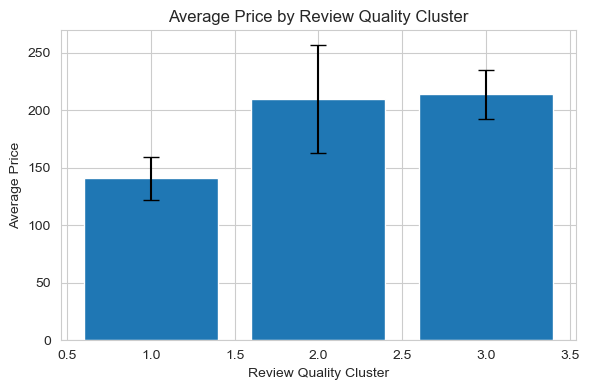

ANOVA p-value: 0.6800


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 假設你的 dataframe 叫 df
# 且已經有 review_cluster（例如 0,1,2 或 Low/Mid/High）

# ====== 1) Compute mean price & CI by cluster ======
summary = (
    df.groupby("review_cluster")["price"]
      .agg(["mean", "count", "std"])
      .reset_index()
)

# 95% confidence interval
summary["ci"] = 1.96 * summary["std"] / np.sqrt(summary["count"])

# ====== 2) Plot ======
plt.figure(figsize=(6, 4))

plt.bar(
    summary["review_cluster"],
    summary["mean"],
    yerr=summary["ci"],
    capsize=6
)

plt.xlabel("Review Quality Cluster")
plt.ylabel("Average Price")
plt.title("Average Price by Review Quality Cluster")

plt.tight_layout()
plt.show()

# ====== 3) (Optional) ANOVA check ======
groups = [
    g["price"].dropna().values
    for _, g in df.groupby("review_cluster")
]
f_stat, p_val = stats.f_oneway(*groups)
print(f"ANOVA p-value: {p_val:.4f}")

In [26]:
import statsmodels.api as sm

X = df[[
    'review_scores_rating',
    'price',
    'host_years_active',
    'accommodates',
    'neighbourhood_group_cleansed_Bronx',
    'neighbourhood_group_cleansed_Brooklyn',
    'neighbourhood_group_cleansed_Manhattan',
    'neighbourhood_group_cleansed_Queens',
    'neighbourhood_group_cleansed_Staten Island'
]]

X = sm.add_constant(X)
y = df['estimated_revenue_l365d']

model = sm.OLS(y, X).fit()
print(model.summary())


                               OLS Regression Results                              
Dep. Variable:     estimated_revenue_l365d   R-squared:                       0.043
Model:                                 OLS   Adj. R-squared:                  0.042
Method:                      Least Squares   F-statistic:                     75.82
Date:                     Fri, 26 Dec 2025   Prob (F-statistic):          5.99e-123
Time:                             12:05:55   Log-Likelihood:            -1.5113e+05
No. Observations:                    13528   AIC:                         3.023e+05
Df Residuals:                        13519   BIC:                         3.023e+05
Df Model:                                8                                         
Covariance Type:                 nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

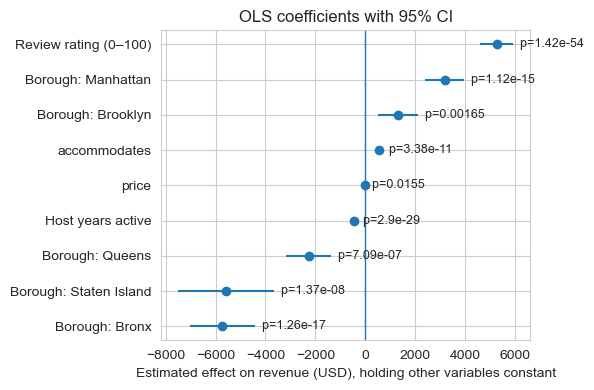

                               OLS Regression Results                              
Dep. Variable:     estimated_revenue_l365d   R-squared:                       0.043
Model:                                 OLS   Adj. R-squared:                  0.042
Method:                      Least Squares   F-statistic:                     75.82
Date:                     Fri, 26 Dec 2025   Prob (F-statistic):          5.99e-123
Time:                             17:17:47   Log-Likelihood:            -1.5113e+05
No. Observations:                    13528   AIC:                         3.023e+05
Df Residuals:                        13519   BIC:                         3.023e+05
Df Model:                                8                                         
Covariance Type:                 nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

In [33]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# ====== 1) Specify X and y (adjust to your df name) ======
# df = ...  # your dataframe

y = df["estimated_revenue_l365d"]

# Choose a logical set of controls (example aligned with your screenshots)
X_cols = [
    "review_scores_rating",
    "price",
    "host_years_active",
    "accommodates",
    "neighbourhood_group_cleansed_Bronx",
    "neighbourhood_group_cleansed_Brooklyn",
    "neighbourhood_group_cleansed_Manhattan",
    "neighbourhood_group_cleansed_Queens",
    "neighbourhood_group_cleansed_Staten Island",
]

X = df[X_cols].copy()
X = sm.add_constant(X)  # adds intercept

# ====== 2) Fit OLS ======
model = sm.OLS(y, X, missing="drop").fit()

# ====== 3) Build coefficient table (exclude intercept) ======
params = model.params.drop("const")
conf = model.conf_int().loc[params.index]
conf.columns = ["ci_low", "ci_high"]

coef_df = pd.DataFrame({
    "coef": params,
    "ci_low": conf["ci_low"],
    "ci_high": conf["ci_high"],
    "pval": model.pvalues.drop("const"),
}).sort_values("coef")

# Optional: rename to nicer labels for portfolio
pretty = {
    "review_scores_rating": "Review rating (0–100)",
    "host_years_active": "Host years active",
    "number_of_reviews": "Number of reviews",
    "neighbourhood_group_cleansed_Bronx": "Borough: Bronx",
    "neighbourhood_group_cleansed_Brooklyn": "Borough: Brooklyn",
    "neighbourhood_group_cleansed_Manhattan": "Borough: Manhattan",
    "neighbourhood_group_cleansed_Queens": "Borough: Queens",
    "neighbourhood_group_cleansed_Staten Island": "Borough: Staten Island",
}
coef_df.index = [pretty.get(i, i) for i in coef_df.index]

# ====== 4) Plot ======
plt.figure(figsize=(6, 4))
ypos = np.arange(len(coef_df))

plt.hlines(y=ypos, xmin=coef_df["ci_low"], xmax=coef_df["ci_high"])
plt.plot(coef_df["coef"], ypos, marker="o", linestyle="None")
plt.axvline(0, linewidth=1)

plt.yticks(ypos, coef_df.index)
plt.xlabel("Estimated effect on revenue (USD), holding other variables constant")
plt.title("OLS coefficients with 95% CI")

# Annotate p-values (optional, lightweight)
for i, p in enumerate(coef_df["pval"].values):
    plt.text(coef_df["ci_high"].iloc[i], i, f"  p={p:.3g}", va="center", fontsize=9)

plt.tight_layout()
plt.show()

print(model.summary())
